In [3]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/the_chosen_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
sample_data.keys()

the_chosen_eddies = ['Eddy22', 'Eddy110', 'Eddy134', 'Eddy133']

In [228]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

def tilt_distance(x, y):
    if np.all(np.isnan(x)):
        return np.nan
    else:
        return np.sqrt( (np.nanmax(x)-np.nanmin(x))**2 + (np.nanmax(y)-np.nanmin(y))**2 )
        

## VG

In [78]:
def nencioli(u, v, lon, lat, a, b):
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    # eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
        min_radial_dist = 3
        # Initialize sublist and index list with the center element
        sublist = [lst[ic]]
        indices = [ic]
        # Move left and check if magnitude increases with tolerance, at least 3 indices
        count_left = 0
        for i in range(ic - 1, -1, -1):
            if count_left < min_radial_dist:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
                count_left += 1
            elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
            else:
                break    
        # Move right and check if magnitude increases with tolerance, at least 3 indices
        count_right = 0
        for i in range(ic + 1, len(lst)):
            if count_right < min_radial_dist:
                sublist.append(lst[i])
                indices.append(i)
                count_right += 1
            elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
                sublist.append(lst[i])
                indices.append(i)
            else:
                break
        return np.array(sublist), indices

    u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        r_squared = 1 - (ss_residuals / ss_total)
        return coefficients, std_err_coeffs, r_squared
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    else:
        xc = yc = np.nan

    return xc, yc


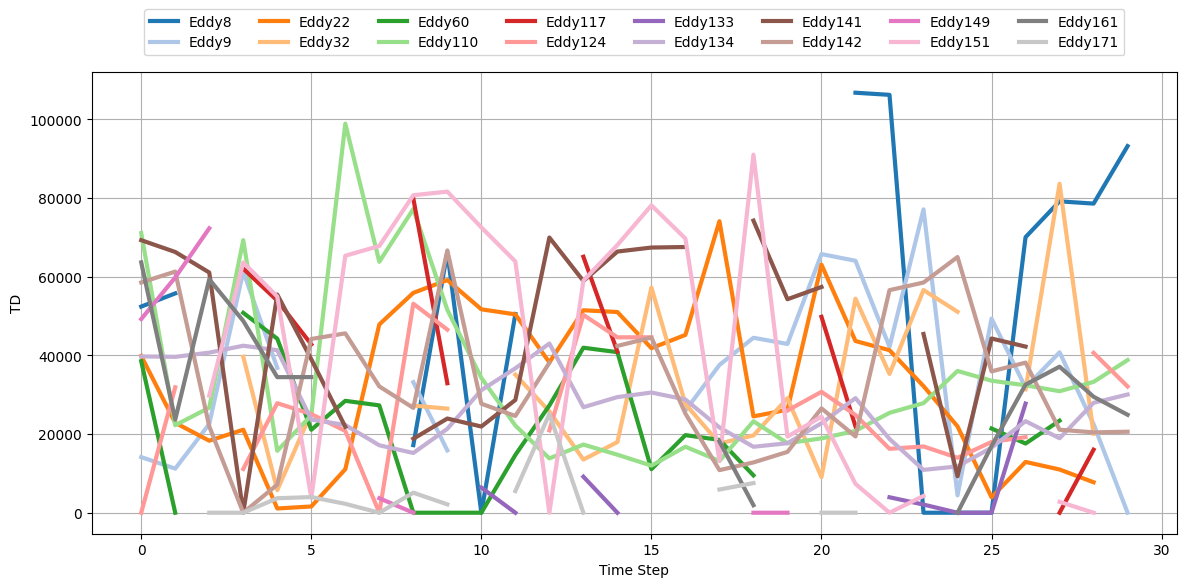

,TD
Eddy171,3823.521692
Eddy133,4470.571784
Eddy60,21427.455588
Eddy149,22305.201993
Eddy134,26545.907138
Eddy124,26763.885252
Eddy161,29062.403834
Eddy32,32674.264535
Eddy142,33390.574672
Eddy110,33490.706121


In [390]:
plt.figure(figsize=(14, 6))

large_sample_eddies = daydic['Day100'].loc[daydic['Day100']['Age'] > 30].index

cmap = plt.colormaps['tab20']
TD_mean = []
for i, sample_eddy in enumerate(large_sample_eddies):
    TD = []
    for t in range(30):
        TD.append(sample_data[sample_eddy]['T'+str(t)]['VG']['TD'][0])
    plt.plot(np.arange(30), TD, label=sample_eddy, linewidth=3, color=cmap(i))
    TD_mean.append(np.nanmean(TD))
df = pd.DataFrame({'TD': TD_mean})
df.index = large_sample_eddies

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(large_sample_eddies) // 2)
plt.xlabel('Time Step')
plt.ylabel('TD')
plt.grid()
plt.show()

df = df.sort_values(by="TD", ascending=True)
df

In [385]:
MAX_DISPLACEMENT = 50000
for eddy in large_sample_eddies:
    start_time = time.time()
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    for t in range(30):
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]

        a, b = 6, 5
        xcs, ycs, zcs = [], [], []
        flag = 1
        for depth_lvl in range(U.shape[-1]):
            if flag:
                u = U[:, :, depth_lvl]
                v = V[:, :, depth_lvl]
                X, Y = np.meshgrid(x, y)
                neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)
                
                neddy = neddy[neddy[:, 2] == var]
                if len(neddy[:, 1]) == 1:

                    n_xc, n_yc = neddy[0, 1], neddy[0, 0] #takign 1st one
                    n_ic = np.where(n_xc == x)[0][0]
                    n_jc = np.where(n_yc == y)[0][0]
                    
                    u1 = u[:, n_jc].squeeze()
                    v1 = v[:, n_jc].squeeze()
                
                    u2 = u[n_ic, :].squeeze()
                    v2 = v[n_ic, :].squeeze()
        
                    xc, yc = moca(u1, v1, u2, v2, n_ic, n_jc, dx)
                    if depth_lvl == 0:
                        R = MAX_DISPLACEMENT - 10
                    else:
                        R = np.sqrt((xcs[-1]-(n_xc + xc))**2 + (ycs[-1]-(n_yc + yc))**2)
                    if R <= MAX_DISPLACEMENT:
                        xcs.append(n_xc + xc)
                        ycs.append(n_yc + yc)
                        zcs.append(z_r[150, 150, depth_lvl])
                    else:
                        flag = 0
                else:
                    flag = 0
                
        if len(xcs) == 0:
            xcs = ycs = zcs = [np.nan]
        sample_data[eddy]['T'+str(t)]['VG'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
    end_time = time.time()
    print(eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")
            

Eddy8
Elapsed time: 1.2133405208587646 seconds
Eddy9
Elapsed time: 1.5162310600280762 seconds
Eddy22
Elapsed time: 3.922036647796631 seconds
Eddy32
Elapsed time: 1.132096290588379 seconds
Eddy60
Elapsed time: 1.150606393814087 seconds
Eddy110
Elapsed time: 2.4504342079162598 seconds
Eddy117
Elapsed time: 0.5293624401092529 seconds
Eddy124
Elapsed time: 0.842902660369873 seconds
Eddy133
Elapsed time: 0.3738059997558594 seconds
Eddy134
Elapsed time: 3.2296385765075684 seconds
Eddy141
Elapsed time: 2.264261245727539 seconds
Eddy142
Elapsed time: 2.2529501914978027 seconds
Eddy149
Elapsed time: 0.4555351734161377 seconds
Eddy151
Elapsed time: 1.280811071395874 seconds
Eddy161
Elapsed time: 1.1259896755218506 seconds
Eddy171
Elapsed time: 0.7921805381774902 seconds


[[-1.8e+04 -3.0e+03 -1.0e+00]]


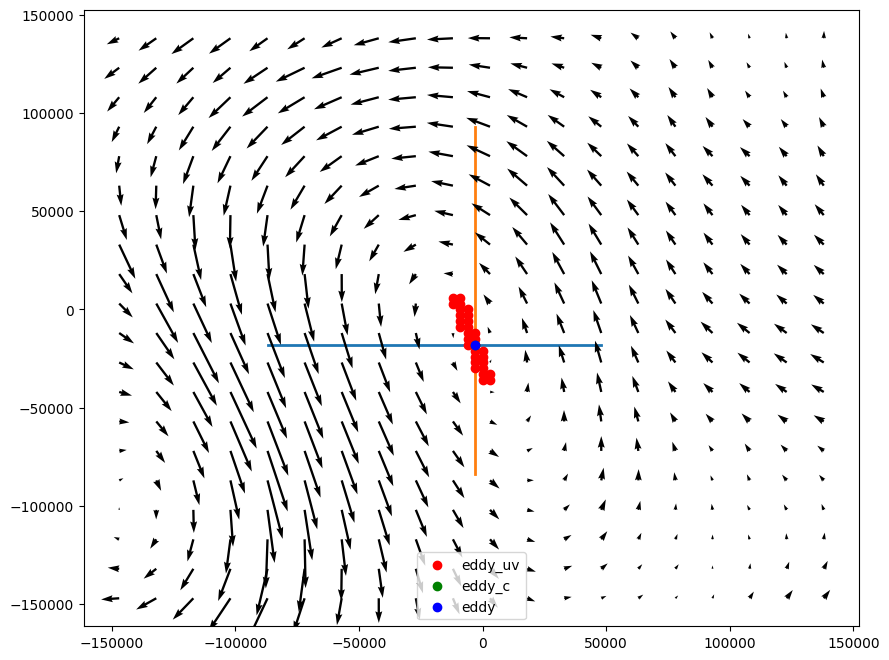

In [391]:
def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
        min_radial_dist = 3
        # Initialize sublist and index list with the center element
        sublist = [lst[ic]]
        indices = [ic]
        # Move left and check if magnitude increases with tolerance, at least 3 indices
        count_left = 0
        for i in range(ic - 1, -1, -1):
            if count_left < min_radial_dist:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
                count_left += 1
            elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
            else:
                break    
        # Move right and check if magnitude increases with tolerance, at least 3 indices
        count_right = 0
        for i in range(ic + 1, len(lst)):
            if count_right < min_radial_dist:
                sublist.append(lst[i])
                indices.append(i)
                count_right += 1
            elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
                sublist.append(lst[i])
                indices.append(i)
            else:
                break
        return np.array(sublist), indices

eddy = 'Eddy110'

t = 5
depth_lvl = 2
u = sample_data[eddy]['T'+str(t)]['U'][:,:,depth_lvl]
v = sample_data[eddy]['T'+str(t)]['V'][:,:,depth_lvl]
x = sample_data[eddy]['T'+str(t)]['x']
y = sample_data[eddy]['T'+str(t)]['y']
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(10,8))
spacing = 5  
plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], 
           u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)
neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)
print(neddy)
plt.scatter(neddy_uv[:, 1], neddy_uv[:, 0], color='r', label='eddy_uv')
plt.scatter(neddy_c[:, 1], neddy_c[:, 0], color='g', label='eddy_c')
plt.scatter(neddy[:, 1], neddy[:, 0], color='b', label='eddy')
for n_ic, n_jc in zip(neddy[:, 1], neddy[:, 0]):
    n_ic, n_jc = np.where(x==n_ic)[0][0], np.where(y==n_jc)[0][0]
    v1 = v[:, n_jc]
    v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
    plt.plot(x[v_ind], [y[n_jc]] * len(v_ind), zorder=0, linewidth=2)
    u2 = u[n_ic, :]
    u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
    plt.plot([x[n_ic]] * len(u_ind), y[u_ind], zorder=0, linewidth=2)
plt.legend()

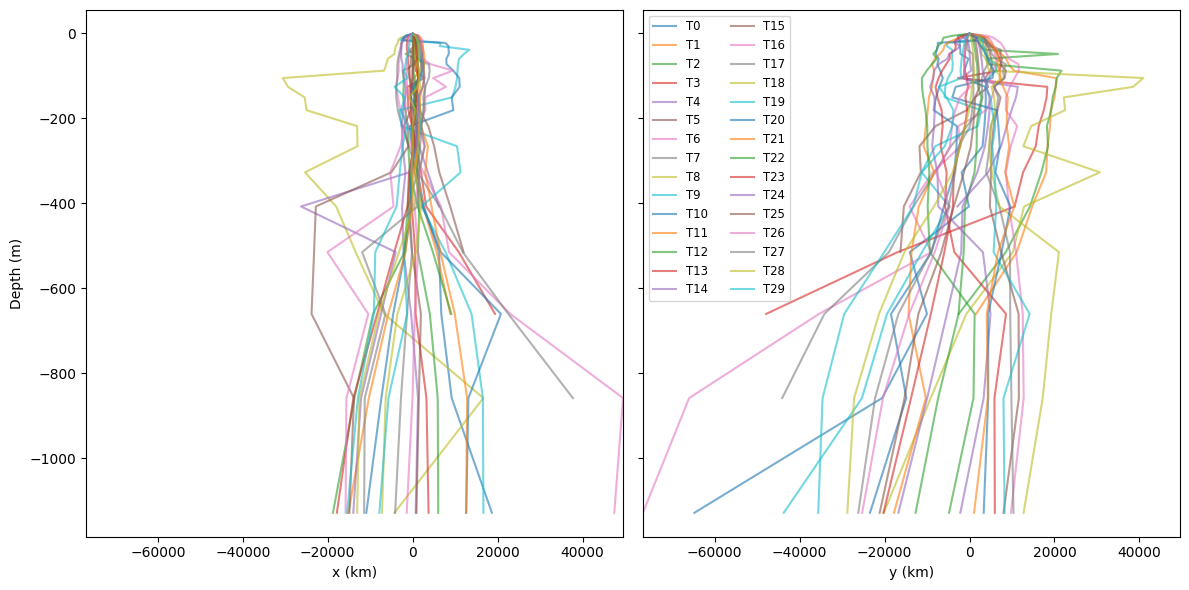

In [392]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[eddy]['T' + str(t)]['VG']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'TD = 106 km')

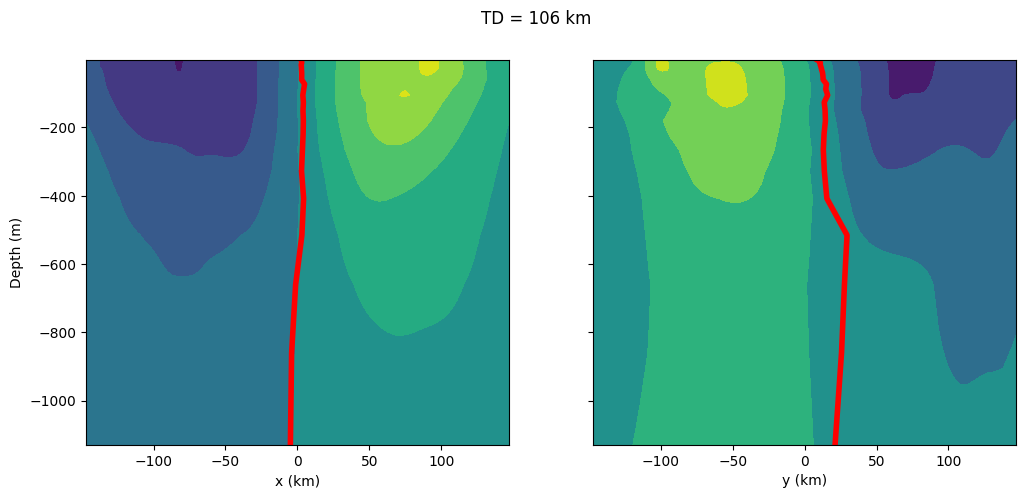

In [393]:
t = 18

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
z = sample_data[eddy]['T'+str(t)]['z']
VG_data = sample_data[eddy]['T'+str(t)]['VG']

xc, yc, zc = VG_data.x/1000, VG_data.y/1000, VG_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(COW_data['TD'][0]/1000)} km" if 'TD' in COW_data and not np.isnan(COW_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

## COW

In [187]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [396]:
CS_THRESH = 0.05
OW_THRESH = -.2
RATIO_THRESH = 2/3
SEARCH_RADIUS_MAX = 50000

for eddy in ['Eddy110']:
    start_time = time.time()
    for t in range(30):

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        X, Y = np.meshgrid(x, y)
    
        cs = np.sqrt(U**2 + V**2)
        ow = normalize_matrix(calc_ow(U, V, x[1]-x[0], x[1]-x[0]))

        xc = yc = 0
        xcs, ycs, zcs = [], [], []
        bottom_flag = 0
        for depth_lvl in range(U.shape[-1]):
            Search_Radius = 5000
            flag = 0
            if not bottom_flag:
                while Search_Radius <= SEARCH_RADIUS_MAX:
                    R = np.sqrt((X - xc)**2 + (Y - yc)**2)
                    mask = R < Search_Radius
                    cur_speed_masked = np.where(mask, cs[:, :, depth_lvl], np.nan) 
                    ow_masked = np.where(mask, ow[:, :, depth_lvl], np.nan) 
                    pot_i, pot_j = np.where((cur_speed_masked < CS_THRESH) & (ow_masked < OW_THRESH))
                    ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
                    if ratio <= RATIO_THRESH and ratio != 0:
                        A = np.array([x[pot_i], y[pot_j]])
                        xc, yc = np.mean(A, axis=1)
                        xcs.append(xc)
                        ycs.append(yc)
                        zcs.append(z_r[150, 150, depth_lvl])
                        flag = 1
                        break
                    Search_Radius += 5000
                if not flag:
                    bottom_flag = 1
        if len(xcs) == 0:
            xcs = ycs = zcs = [np.nan]
        sample_data[eddy]['T'+str(t)]['COW'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
    end_time = time.time()
    print(eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")


Eddy110
Elapsed time: 0.43700098991394043 seconds


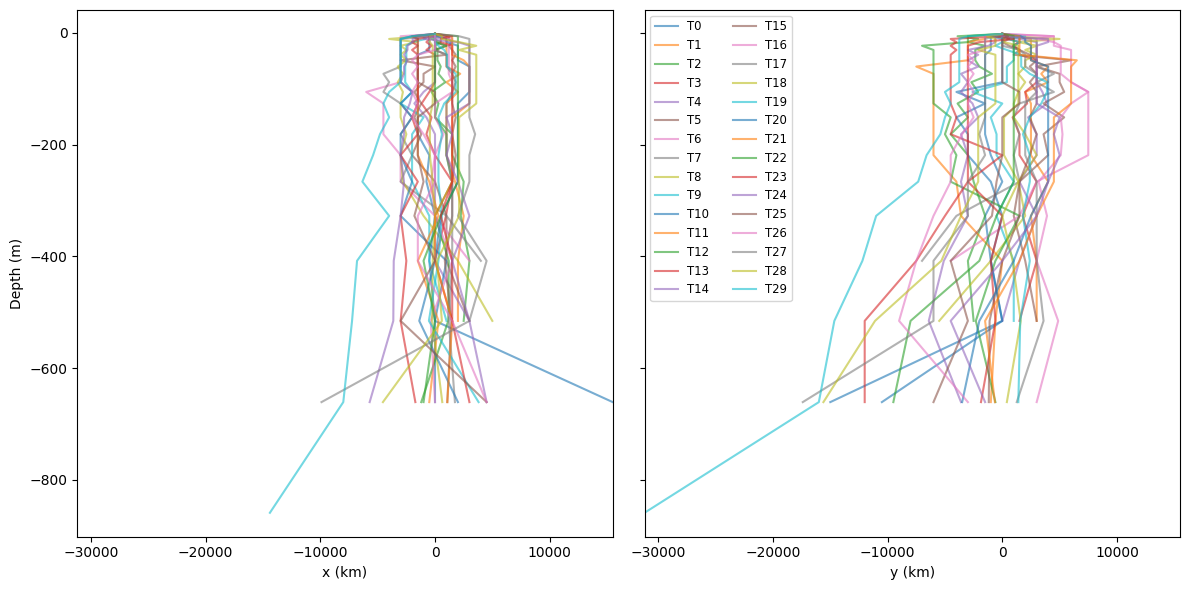

In [398]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[eddy]['T' + str(t)]['COW']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'TD = 106 km')

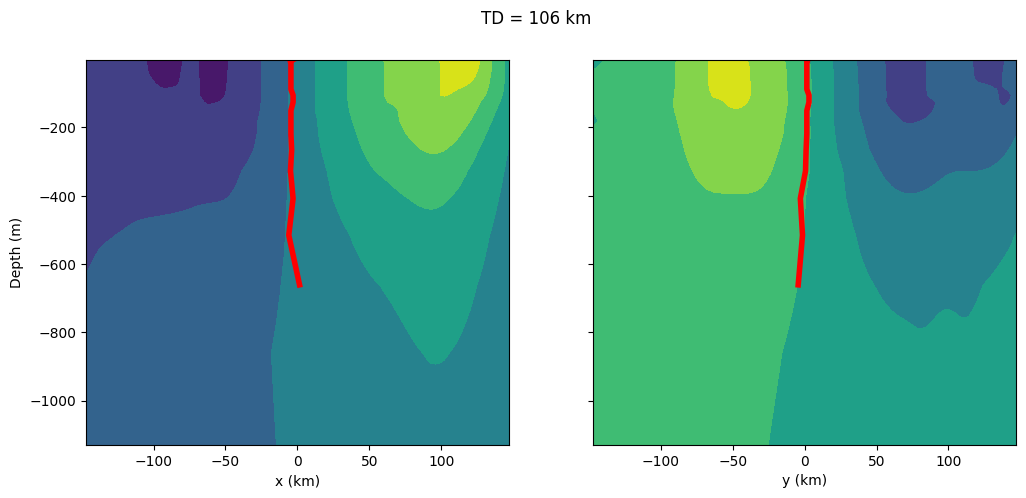

In [399]:
t = 25

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
z = sample_data[eddy]['T'+str(t)]['z']
VG_data = sample_data[eddy]['T'+str(t)]['COW']

xc, yc, zc = VG_data.x/1000, VG_data.y/1000, VG_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(COW_data['TD'][0]/1000)} km" if 'TD' in COW_data and not np.isnan(COW_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

## LNAM

In [212]:
def calc_lnam(x, y, uu, vv):
    f = -1
    dx, dy = np.zeros_like(x), np.zeros_like(x)
    dux, duy, dvx, dvy = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)
    dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
    dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]
    dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
    duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
    dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
    dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]
    epsilon = 1e-10  # A small number to prevent division by zero
    sn = np.divide((dux / (dx + epsilon)) - (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    ss = np.divide((dvx / (dx + epsilon)) + (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    om = np.divide((dvx / (dx + epsilon)) - (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    # div = np.divide((dux / (dx + epsilon)) + (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    okubo = sn**2 + ss**2 - om**2  # in s^-2
    
    # Initialization
    LNAM, LOW = np.full_like(uu, np.nan), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int) # 2b is the side length of the local box
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    return LNAM, LOW

In [332]:
the_chosen_eddies

['Eddy22', 'Eddy149', 'Eddy134', 'Eddy133']

In [400]:
from scipy.ndimage import maximum_filter, minimum_filter
WINDOW_SIZE = 5
SEARCH_RADIUS = 100000
MAX_DISPLACEMENT = 50000
for eddy in ['Eddy110']:
    start_time = time.time()
    for t in range(30):
        
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        X, Y = np.meshgrid(x, y)
        dx = x[1] - x[0]

        ic_pre, jc_pre = U.shape[0]//2, U.shape[1]//2
        xcs, ycs, zcs = [], [], []
        bottom_flag = 0
        for depth_lvl in range(U.shape[-1]):
            if not bottom_flag:
                u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
                lnam, _ = calc_lnam(X, Y, u, v)
                IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
                R = np.sqrt((ic_pre - IC)**2 + (jc_pre - JC)**2) * dx
                lnam = np.where(R < SEARCH_RADIUS, lnam, np.nan)
                if eddies[eddy].iloc[0].Vort < 0:
                    local_maxima = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
                    local_maxima_positions = (lnam == local_maxima)
                    ic, jc = np.argwhere(local_maxima_positions).T
                else:
                    local_minima = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
                    local_minima_positions = (lnam == local_minima)
                    ic, jc = np.argwhere(local_minima_positions).T

                if len(ic) > 0:
                    R = np.sqrt((ic - ic_pre)**2 + (jc - jc_pre)**2) * dx
                    ic = ic[R == np.nanmin(R)][0]
                    jc = jc[R == np.nanmin(R)][0]
                    R = R[R == np.nanmin(R)][0]
                    if R <= MAX_DISPLACEMENT:
                        xcs.append(x[ic])
                        ycs.append(y[jc])
                        zcs.append(z_r[150, 150, depth_lvl])
                        ic_pre, jc_pre = ic, jc
                    else:
                        bottom_flag = 1
                else:
                    bottom_flag = 1
        sample_data[eddy]['T'+str(t)]['LNAM'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
        print(t)
    end_time = time.time()
    print(eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Eddy110
Elapsed time: 333.6267774105072 seconds


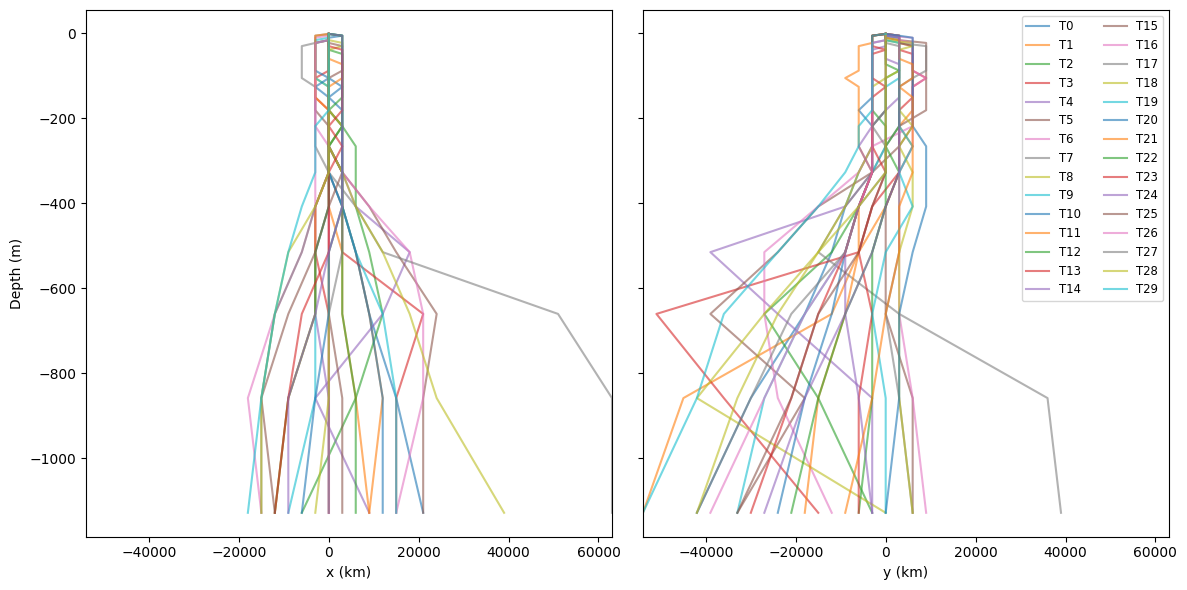

In [401]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

x_min, x_max = float('inf'), float('-inf')

for t in range(30):
    data = sample_data[eddy]['T' + str(t)]['LNAM']
    x_vals, y_vals = data['x'] - data['x'][0], data['y'] - data['y'][0]
    ax1.plot(x_vals, data['Depth'], alpha=0.6)
    ax2.plot(y_vals, data['Depth'], alpha=0.6, label='T' + str(t))
    x_min, x_max = min(x_min, x_vals.min(), y_vals.min()), max(x_max, x_vals.max(), y_vals.max())

ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)
ax1.set_xlabel("x (km)"); ax1.set_ylabel("Depth (m)")
ax2.set_xlabel("y (km)")
ax2.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'TD = 106 km')

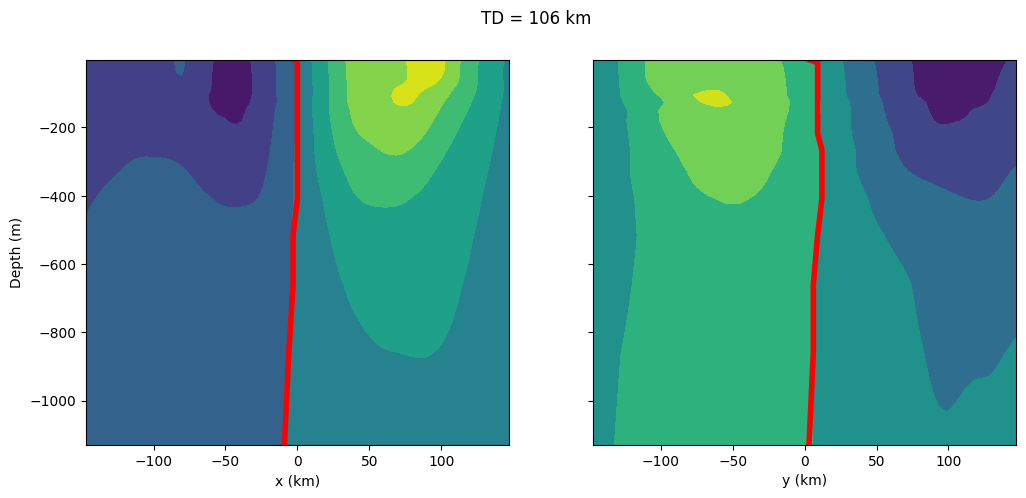

In [402]:

t = 20

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']/1000
y = sample_data[eddy]['T'+str(t)]['y']/1000
z = sample_data[eddy]['T'+str(t)]['z']
VG_data = sample_data[eddy]['T'+str(t)]['LNAM']

xc, yc, zc = VG_data.x/1000, VG_data.y/1000, VG_data.Depth

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
X, Z = np.meshgrid(x, z)
axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T)
axs[0].plot(xc, zc, linewidth=4, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T)
axs[1].plot(yc, zc, linewidth=4, color='r')
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
TD = f"{round(COW_data['TD'][0]/1000)} km" if 'TD' in COW_data and not np.isnan(COW_data['TD'][0]) else 'NaN'
plt.suptitle(f'TD = {TD}')

## Sample Data Analysis

In [312]:
def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated/1000, y_rotated/1000

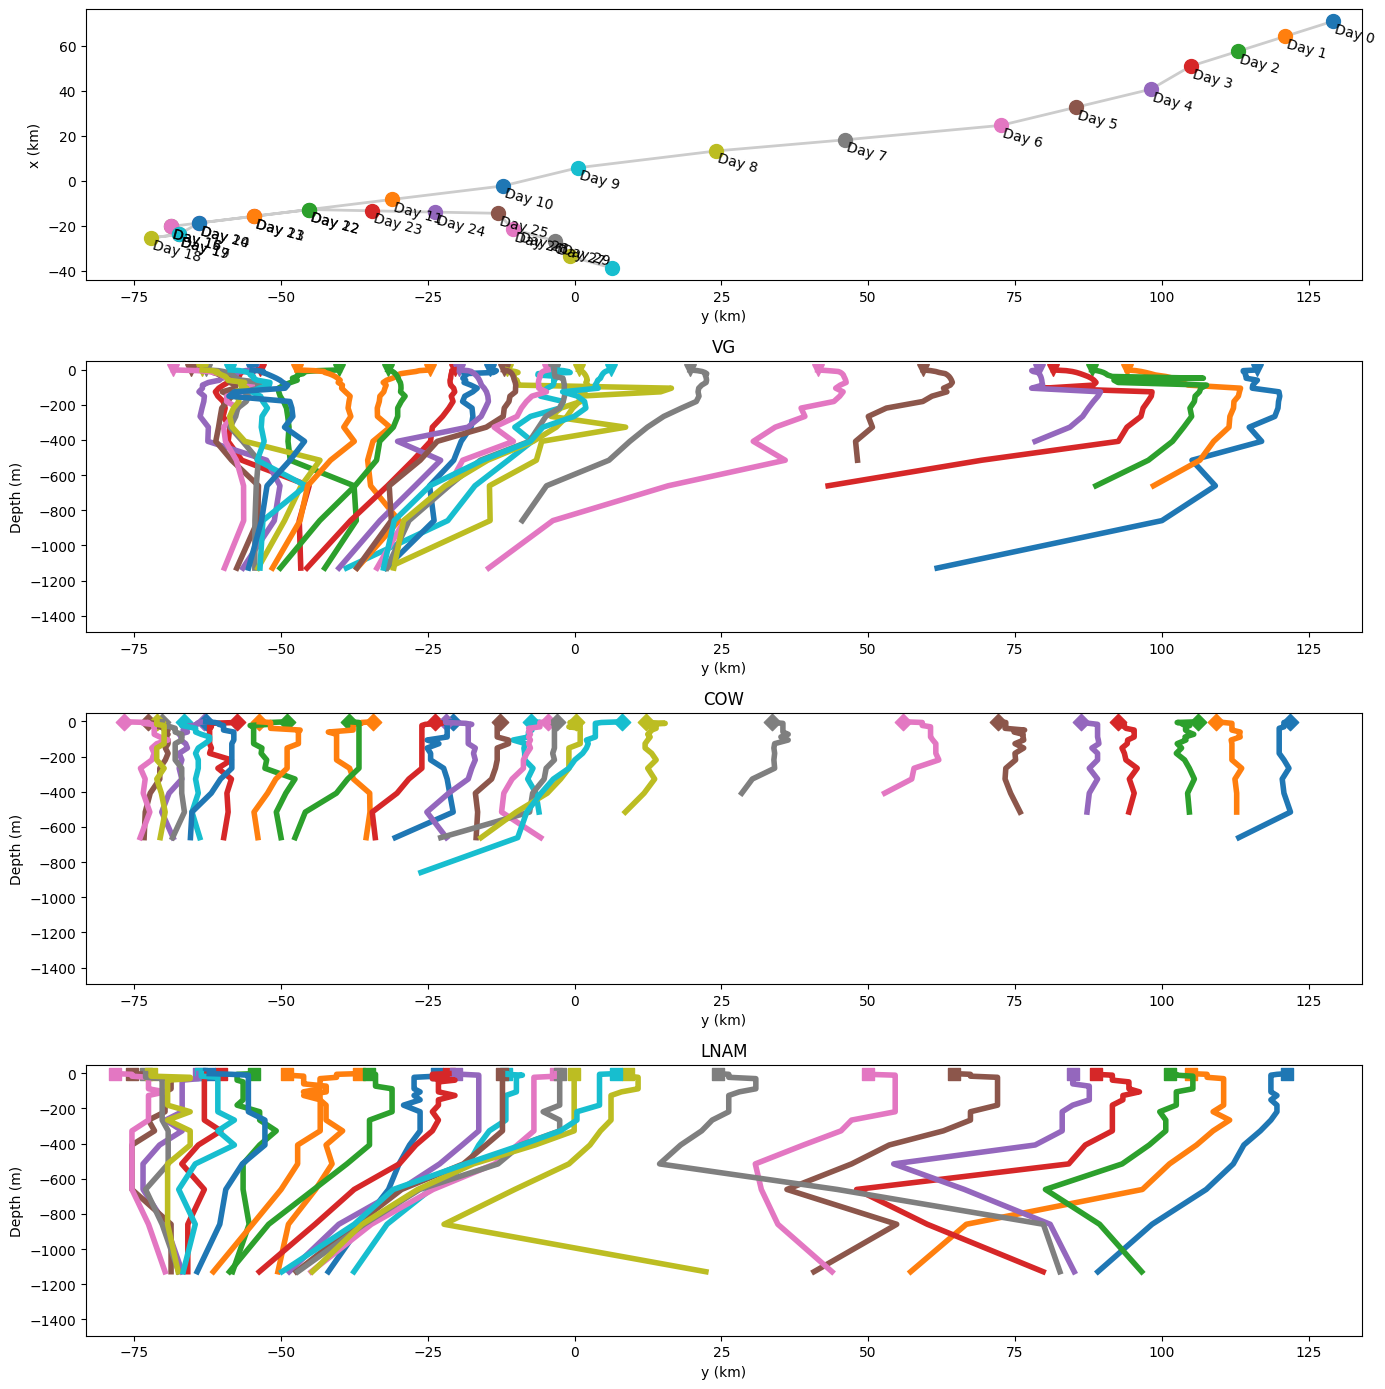

In [405]:
import matplotlib.cm as cm

fig, axs = plt.subplots(4, 1, figsize=(14, 14))

# eddy = 'Eddy133' # AE tilt
# eddy = 'Eddy134' # CE non-tilt
# eddy = 'Eddy22' # AE no-tilt
eddy = 'Eddy110' # AE tilt 
# eddy = 'Eddy134'

DEPTH_LVL_LIMIT = 30

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
# x /= 1000
# y /= 1000
eddy_path = pd.DataFrame({'x': x, 'y': y})

# Plot the eddy path
axs[0].plot(eddy_path['y'], eddy_path['x'], linewidth=2, color='k', alpha=.2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')

y_min = float('inf')
y_max = float('-inf')
for t in range(30):
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x1, y1 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y1 = y1 + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x2, y2 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y2 = y2 + eddy_path.iloc[t].y

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x3, y3 = rotate_20_clockwise(time_data['x'], time_data['y'])
    y3 = y3 + eddy_path.iloc[t].y

    if np.all(np.isnan(y1)):
        y1 = 0
    if np.all(np.isnan(y2)):
        y2 = 0
    if np.all(np.isnan(y3)):
        y3 = 0

    y_min = min(y_min, np.nanmin(y1), np.nanmin(y2), np.nanmin(y3), np.nanmin(eddy_path['y']))
    y_max = max(y_max, np.nanmax(y1), np.nanmax(y2), np.nanmax(y3), np.nanmax(eddy_path['y']))
y_min -= 5
y_max += 5

# y_min = -20
# y_max = 15

cmap = plt.colormaps['tab10']
i = 0
# for t in [0,10,14,16,18,20,22,24,27, 29]:
for t in range(30):

    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=100, zorder=5)

    # time_data = sample_data[eddy]['T' + str(t)]['VG']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=70, zorder=5, marker='v', color=cmap(i))
    # time_data = sample_data[eddy]['T' + str(t)]['COW']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=70, zorder=5, marker='D', color=cmap(i))
    # time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    # x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    # x, y = x[0] + eddy_path.iloc[t]['x'], y[0] + eddy_path.iloc[t]['y']
    # axs[0].scatter(y, x, s=70, zorder=5, marker='s', color=cmap(i))

    if t in [28, 29]:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='right', va='bottom', zorder=6, rotation=-15)
    else:
        axs[0].text(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], 'Day ' + str(t), ha='left', va='top', zorder=6, rotation=-15)
    
    time_data = sample_data[eddy]['T' + str(t)]['VG']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[1].plot(y, z, linewidth=4)
    axs[1].scatter(y[0], z[0], s=70, marker='v')
    # axs[1].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[1].set_ylim([50, z_r[150, 150, 23]])
    axs[1].invert_yaxis()
    axs[1].set_title('VG')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['COW']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[2].plot(y, z, linewidth=4)
    axs[2].scatter(y[0], z[0], s=70, marker='D')
    # axs[2].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[2].set_ylim([50, z_r[150, 150, 23]])
    axs[2].invert_yaxis()
    axs[2].set_title('COW')
    axs[2].set_xlabel('y (km)')
    axs[2].set_ylabel('Depth (m)')

    time_data = sample_data[eddy]['T' + str(t)]['LNAM']
    x, y = rotate_20_clockwise(time_data['x'], time_data['y'])
    y = y + eddy_path.iloc[t].y
    z = time_data['Depth']
    axs[3].plot(y, z, linewidth=4)
    axs[3].scatter(y[0], z[0], s=70, marker='s')
    # axs[3].set_ylim([200, z_r[150, 150, DEPTH_LVL_LIMIT-1]])
    axs[3].set_ylim([50, z_r[150, 150, 23]])
    axs[3].invert_yaxis()
    axs[3].set_title('LNAM')
    axs[3].set_xlabel('y (km)')
    axs[3].set_ylabel('Depth (m)')

    i += 1

axs[0].set_xlim(y_min, y_max)
axs[1].set_xlim(y_min, y_max)
axs[2].set_xlim(y_min, y_max)
axs[3].set_xlim(y_min, y_max)

# plt.suptitle(eddy)
plt.tight_layout()
plt.show()

In [406]:
# with open('/srv/scratch/z5297792/Sample/the_chosen_sample_data.pkl.pkl', 'wb') as file:
#     pickle.dump(sample_data, file)